# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import re
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Processing

In [2]:
df = pd.read_csv('Stock_Features_With_Volume.csv', parse_dates=['Date'])
df = df.dropna().reset_index(drop=True)
tickers = df['Ticker'].unique()

def sanitize_ticker(ticker):
    return re.sub(r'[^a-zA-Z0-9]', '_', ticker)

df

,Date,Ticker,Closing_Price,Simple_Return,Log_Return,Rolling_20D_Volatility,SMA_50,SMA_200,EMA_12,EMA_26,MACD,RSI,SMA_20,Upper_BB,Lower_BB,Volume
0,2020-08-31,A UN Equity,100.42,0.042458,0.041582,0.051052,86.923333,86.923333,83.049681,77.757683,5.291999,100.000000,86.923333,87.025438,86.821229,7467113.0
1,2020-09-30,A UN Equity,100.94,0.005178,0.005165,0.052294,88.925714,88.925714,85.802038,79.474891,6.327147,100.000000,88.925714,89.030303,88.821125,8263759.0
2,2020-10-30,A UN Equity,102.09,0.011393,0.011328,0.050788,90.571250,90.571250,88.307878,81.150084,7.157794,100.000000,90.571250,90.672826,90.469674,6669957.0
3,2020-11-30,A UN Equity,116.90,0.145068,0.135464,0.055770,93.496667,93.496667,92.706666,83.798226,8.908440,100.000000,93.496667,93.608207,93.385126,12056109.0
4,2020-12-31,A UN Equity,118.49,0.013601,0.013510,0.054541,95.996000,95.996000,96.673333,86.367987,10.305346,100.000000,95.996000,96.105081,95.886919,11779762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26340,2024-10-31,ZTS UN Equity,178.78,-0.084963,-0.088790,0.078401,177.324000,173.239464,179.556095,176.668246,2.887849,46.843210,177.813000,177.969802,177.656198,11608946.0
26341,2024-11-29,ZTS UN Equity,175.25,-0.019745,-0.019942,0.078564,177.521600,173.274737,178.893619,176.563191,2.330428,50.367498,178.253500,178.410628,178.096372,14140432.0
26342,2024-12-31,ZTS UN Equity,162.93,-0.070300,-0.072893,0.079290,177.609200,173.096379,176.437678,175.553325,0.884353,51.763516,177.611000,177.769580,177.452420,14041774.0
26343,2025-01-31,ZTS UN Equity,170.90,0.048917,0.047758,0.078210,177.819600,173.059153,175.585727,175.208634,0.377093,48.155725,178.005500,178.161920,177.849080,14196273.0


# Configuration

In [3]:
TIME_STEPS = 5           # Number of lagged returns to use as features
TEST_MONTHS = 5          # Predict 5 future months
XGB_PARAMS = {
    'objective': 'reg:squarederror',
    'n_estimators': 150,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': 1
}

# Output Storage Preparation

In [4]:
results = {}
model_dir = "xgb_models"
os.makedirs(model_dir, exist_ok=True)

# Helper Function to Create Lags

In [5]:
def create_lagged_features(series, time_steps):
    lagged_data = pd.concat([
        series.shift(i).rename(f'lag_{i}') for i in range(time_steps, 0, -1)
    ], axis=1)
    return lagged_data

# Function to Train and Forecast Stocks

In [6]:
def train_and_forecast_ticker(df_ticker, ticker):
    # Generate lag features on log_return
    lagged_features = create_lagged_features(df_ticker['Log_Return'], TIME_STEPS)
    df_lagged = pd.concat([df_ticker, lagged_features], axis=1).dropna().reset_index(drop=True)

    # Split into train/test
    df_train = df_lagged.iloc[:-TEST_MONTHS].copy()
    df_test = df_lagged.iloc[-TEST_MONTHS:].copy()

    lag_cols = [f'lag_{i}' for i in range(TIME_STEPS, 0, -1)]

    X_train, y_train = df_train[lag_cols], df_train['Log_Return']

    # Train model
    model = xgb.XGBRegressor(**XGB_PARAMS)
    model.fit(X_train, y_train)

    # Save model
    safe_ticker = sanitize_ticker(ticker)
    model_path = os.path.join(model_dir, f"{safe_ticker}_simple.json")
    model.save_model(model_path)

    # Recursive future prediction loop (only lagged returns)
    last_known_close = df_train['Closing_Price'].iloc[-1]
    last_known_lags = df_train[lag_cols].iloc[-1].values.copy()
    predicted_log_returns = []

    for _ in range(TEST_MONTHS):
        # Only use lagged returns as features
        input_features = last_known_lags.reshape(1, -1)
        next_log_return = model.predict(input_features)[0]
        predicted_log_returns.append(next_log_return)

        # Update lag window
        last_known_lags = np.roll(last_known_lags, -1)
        last_known_lags[-1] = next_log_return

    # Convert predicted log returns to prices
    predicted_prices = [last_known_close]
    for log_ret in predicted_log_returns:
        next_price = predicted_prices[-1] * np.exp(log_ret)
        predicted_prices.append(next_price)

    predicted_prices = predicted_prices[1:]  # Remove the initial known price

    # Extract actual prices for comparison
    actual_prices = df_test['Closing_Price'].values

    # Calculate model performance scores
    mse = mean_squared_error(actual_prices, predicted_prices)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)

    # Expected return on log returns; calculated as average of log returns over test period
    expected_return = np.mean(predicted_log_returns)

    # Return all results
    return {
        "Actual Prices": actual_prices,
        "Predicted Prices": predicted_prices,
        "Expected Return": expected_return,
        "Model Path": model_path,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

# Perform Forecasting on Stocks and Save Results

In [7]:
for ticker in tickers:
    print(f"Training XGBoost for {ticker}...")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)
    results[ticker] = train_and_forecast_ticker(df_ticker, ticker)
    print(f"Finished training {ticker}.")

with open("xgb_results_simple.pkl", "wb") as f:
    pickle.dump(results, f)

Training XGBoost for A UN Equity...
Finished training A UN Equity.
Training XGBoost for AAPL UW Equity...
Finished training AAPL UW Equity.
Training XGBoost for ABBV UN Equity...
Finished training ABBV UN Equity.
Training XGBoost for ABT UN Equity...
Finished training ABT UN Equity.
Training XGBoost for ACGL UW Equity...
Finished training ACGL UW Equity.
Training XGBoost for ACN UN Equity...
Finished training ACN UN Equity.
Training XGBoost for ADBE UW Equity...
Finished training ADBE UW Equity.
Training XGBoost for ADI UW Equity...
Finished training ADI UW Equity.
Training XGBoost for ADM UN Equity...
Finished training ADM UN Equity.
Training XGBoost for ADP UW Equity...
Finished training ADP UW Equity.
Training XGBoost for ADSK UW Equity...
Finished training ADSK UW Equity.
Training XGBoost for AEE UN Equity...
Finished training AEE UN Equity.
Training XGBoost for AES UN Equity...
Finished training AES UN Equity.
Training XGBoost for AFL UN Equity...
Finished training AFL UN Equity.


# Visualize Results

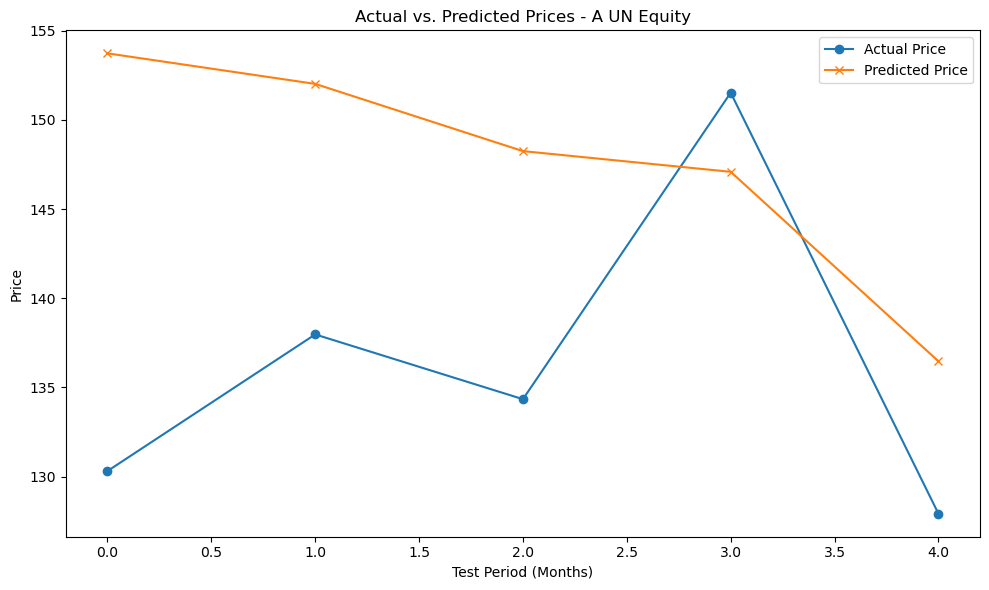

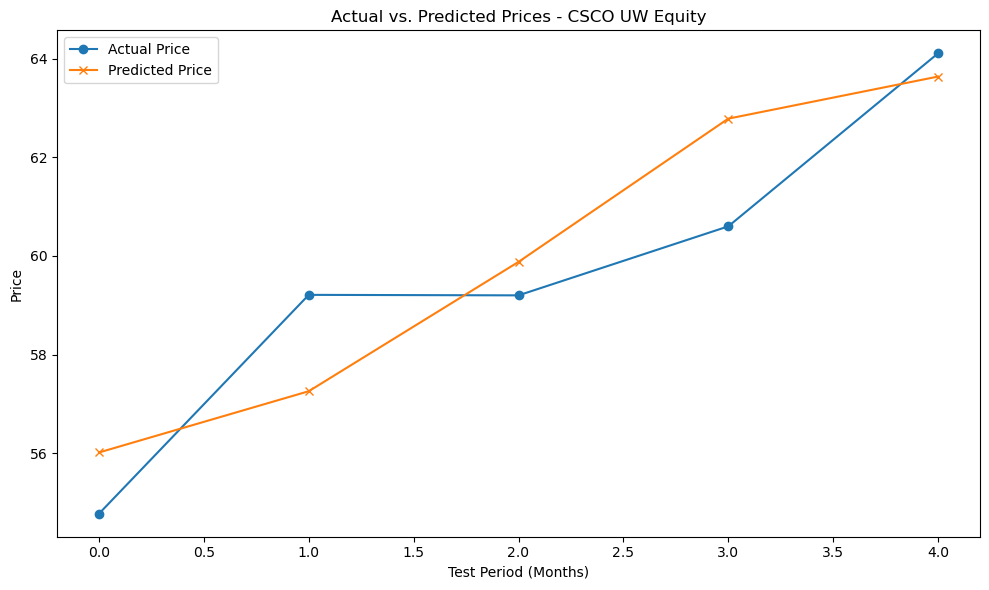

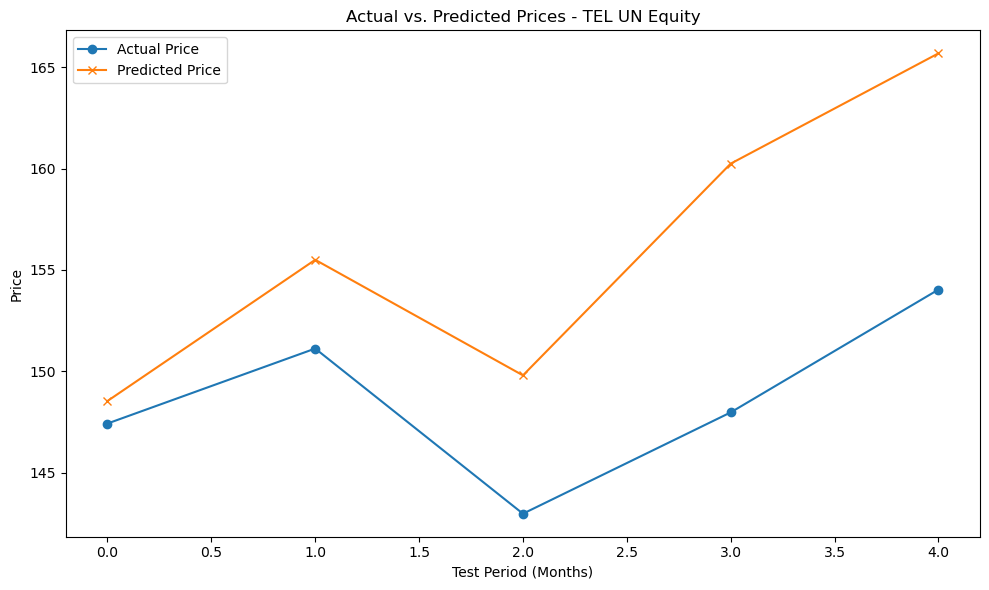

In [8]:
tickers_to_visualize = ["A UN Equity", "CSCO UW Equity", "TEL UN Equity"]
for ticker in tickers_to_visualize:
    data = results[ticker]
    actual_prices = data["Actual Prices"]
    predicted_prices = data["Predicted Prices"]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(actual_prices)), actual_prices, label="Actual Price", marker='o')
    plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Price", marker='x')
    plt.title(f"Actual vs. Predicted Prices - {ticker}")
    plt.xlabel("Test Period (Months)")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
results_df = pd.DataFrame.from_dict(
    {ticker: {"Expected Return": data["Expected Return"], "MSE": data["MSE"], "MAE": data["MAE"], "R2": data["R2"]}
     for ticker, data in results.items()},
    orient='index'
).reset_index().rename(columns={'index': 'Ticker'})

results_df

,Ticker,Expected Return,MSE,MAE,R2
0,A UN Equity,-0.016878,206.317659,12.868878,-1.996010
1,AAPL UW Equity,0.006475,257.384645,12.056889,-3.032106
2,ABBV UN Equity,0.011859,401.923539,16.160157,-1.569969
3,ABT UN Equity,-0.005204,208.793216,9.705601,-1.293707
4,ACGL UW Equity,0.021623,729.794486,25.416682,-60.695283
...,...,...,...,...,...
474,XYL UN Equity,0.004058,229.333963,13.842015,-8.277945
475,YUM UN Equity,-0.003026,141.252229,10.882435,-0.549272
476,ZBH UN Equity,-0.032191,112.151518,9.990212,-13.435550
477,ZBRA UW Equity,0.034218,3529.120825,40.497274,-2.480996


In [10]:
results_df.describe()

,Expected Return,MSE,MAE,R2
count,479.000000,4.790000e+02,479.000000,479.000000
mean,0.008644,1.321025e+04,30.647599,-9.271848
std,0.025260,2.143196e+05,104.033659,18.648667
min,-0.122633,1.287420e+00,0.991179,-191.097184
25%,-0.005097,5.149592e+01,6.227374,-9.303733
50%,0.008668,2.385891e+02,13.547025,-3.163156
75%,0.021641,1.129762e+03,29.979618,-1.057342
max,0.145522,4.672686e+06,2066.451367,0.759375
